# One Feature Model Scores LB 0.930!
In this notebook, we will explore the Kaggle Ion Comp data and explore a one feature model. The LB result of 0.930 is enlightening.

Here we manually remove signal drift. Note that it is better to use machine learning to remove drift, but doing it by hand once allows us to understand its nature and build better models later.

# Load Libraries and Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
import graphviz
from sklearn import tree

In [2]:
test = pd.read_csv('../input/liverpool-ion-switching/test.csv')
train = pd.read_csv('../input/liverpool-ion-switching/train.csv')
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


# Description of Data
The training data is recordings in time. At each 10,000th of a second, the strength of the signal was recorded and the number of ion channels open was recorded. It is our task to build a model that predicts the number of open channels from signal at each time step. Furthermore we are told that the data was recorded in batches of 50 seconds. Therefore each 500,000 rows is one batch. The training data contains 10 batches and the test data contains 4 batches. Let's display the number of open channels and signal strength together for each training batch.

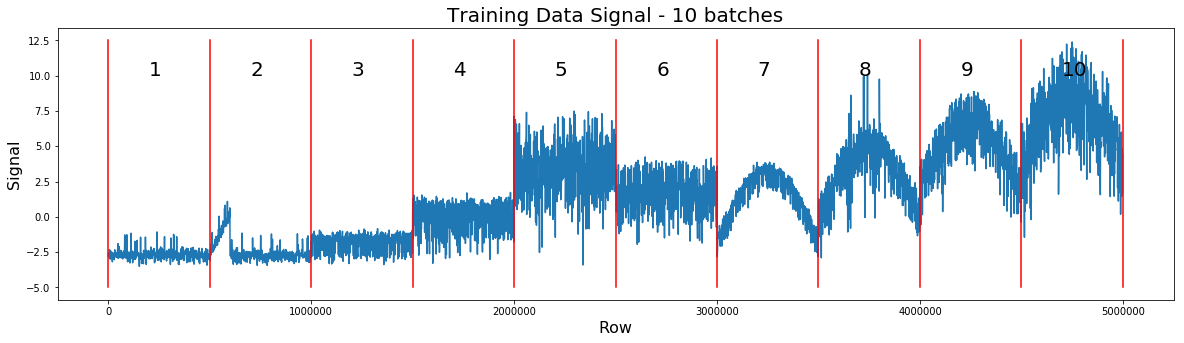

In [3]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

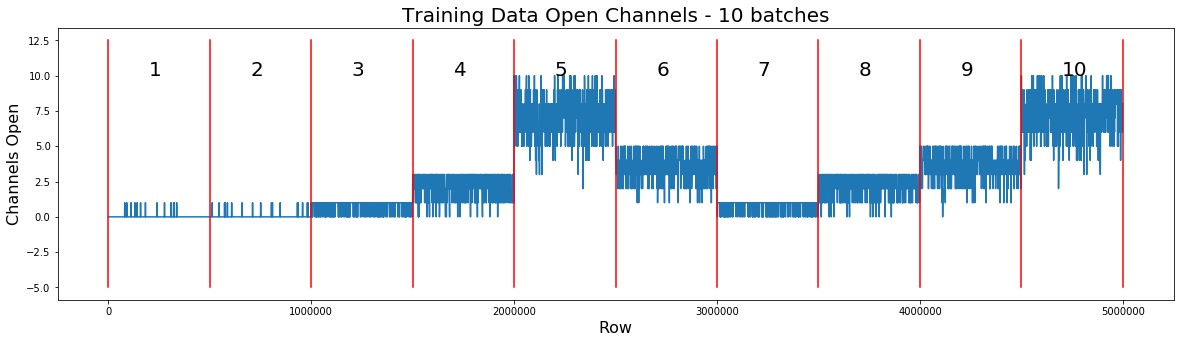

In [4]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

## Reflection
From the plots above, it looks like they used 5 different synthetic models. One model produced maximum 1 channel open with low probability (batches 1 and 2). One model produced maximum 1 channel open with high probability (batches 3 and 7). One model produced maximum 3 channels open (batches 4 and 8). One model produced maximum 5 channels open (batches 6 and 9) and one model produced maximum 10 channels open (batches 7 and 10). Furthermore drift was added to batches 7, 8, 9, 10. And the beginning of batch 2.

According to the paper [here][1], the data is synthesized. Also "electrophysiological" noise and drift were added. Drift is a signal bias causing the signal to no longer be a horizontal line like batches 2, 7, 8, 9, 10 above.

> Data description and dataset construction. Ion channel dwell-times were
simulated using the method of Gillespie 43 from published single channel models.
Channels are assumed to follow a stochastic Markovian process and transition
from one state to the next simulated by randomly sampling from a lifetime
probability distribution calculated for each state. Authentic “electrophysiological”
noise was added to these events by passing the signal through a patch-clamp
amplifier and recording it back to file with CED’s Signal software via an Axon
electronic “model cell”. In some datasets additional drift was applied to the final
data with Matlab. Two different stochastic gating models, (termed M1 and M2)
were used to generate semi-synthetic ion channel data. M1 is a low open probability model from ref. 41 (Fig. 3a, b), typically no more than one ion channel opens
simultaneously. Model M2 is from refs. 42,44 and has a much higher open probability (Fig. 3c, d), consequently up to five channels opened simultaneously and there are few instances of zero channels open.


[1]: https://www.nature.com/articles/s42003-019-0729-3


# Correlation Between Signal and Open Channels
Let's look closely at random intervals of signal and open channels to observe how they relate. We notice that they are highly correlated and move up and down together. Therefore we can probabily predict open channels from the one feature signal. The only complication is the synthetic drift that was added. So we will remove it.

#########################
### Random 288832 to 293832
#########################


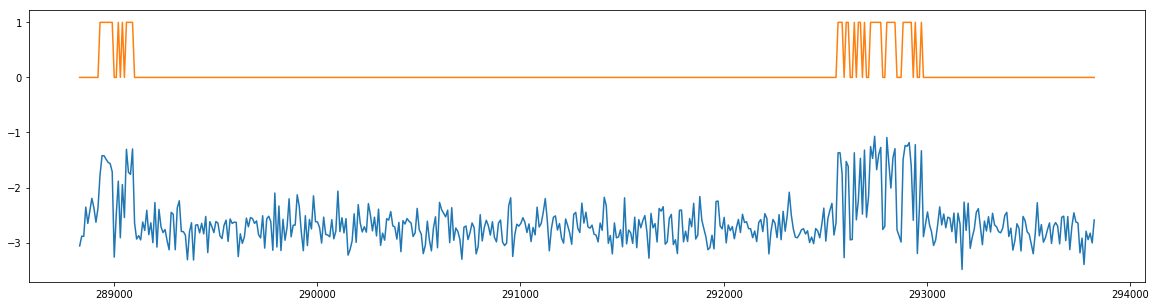

#########################
### Random 4404084 to 4409084
#########################


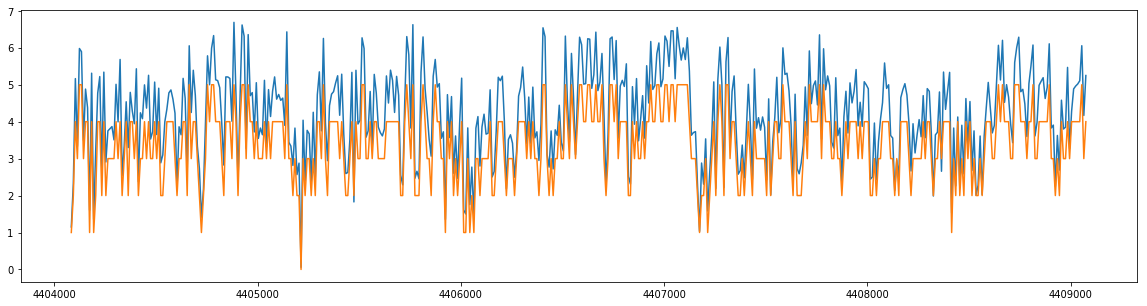

#########################
### Random 4365017 to 4370017
#########################


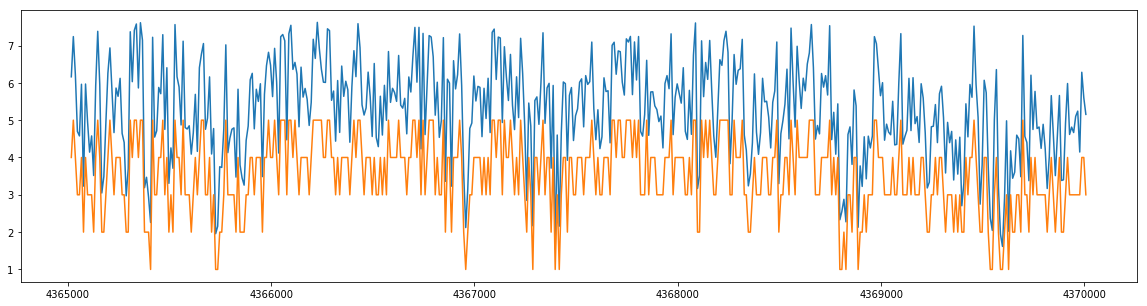

#########################
### Random 4302538 to 4307538
#########################


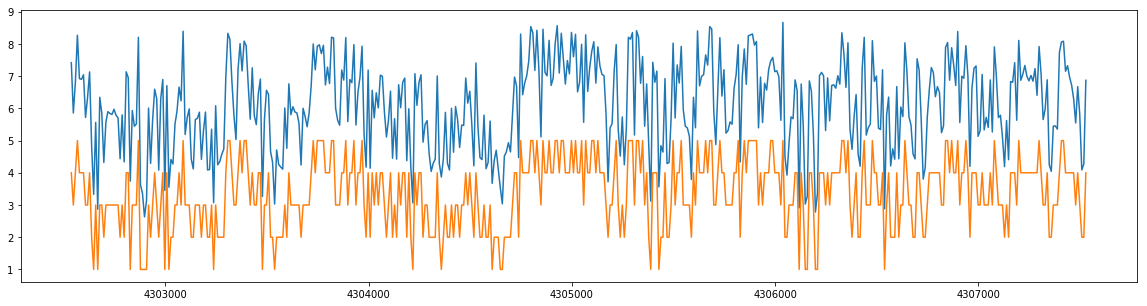

#########################
### Random 947692 to 952692
#########################


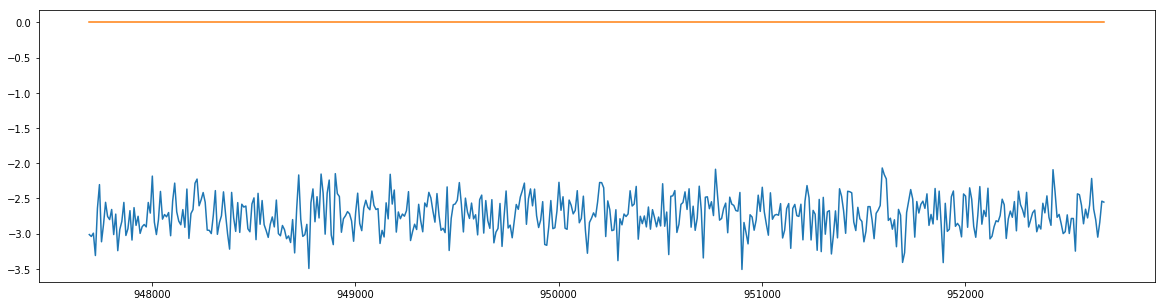

#########################
### Random 2260612 to 2265612
#########################


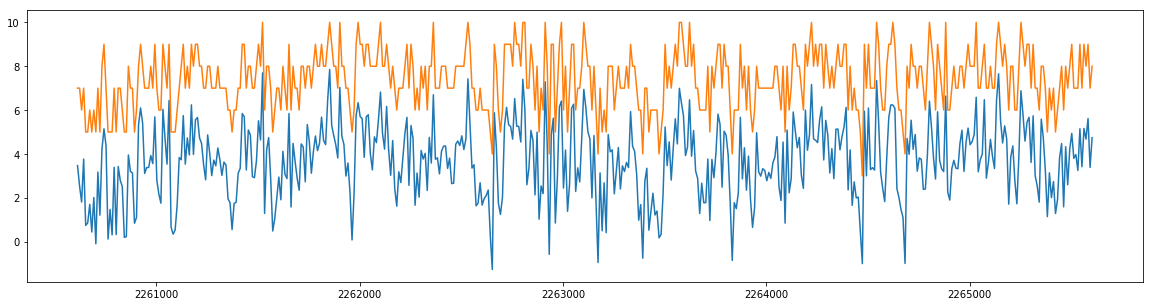

#########################
### Random 4054051 to 4059051
#########################


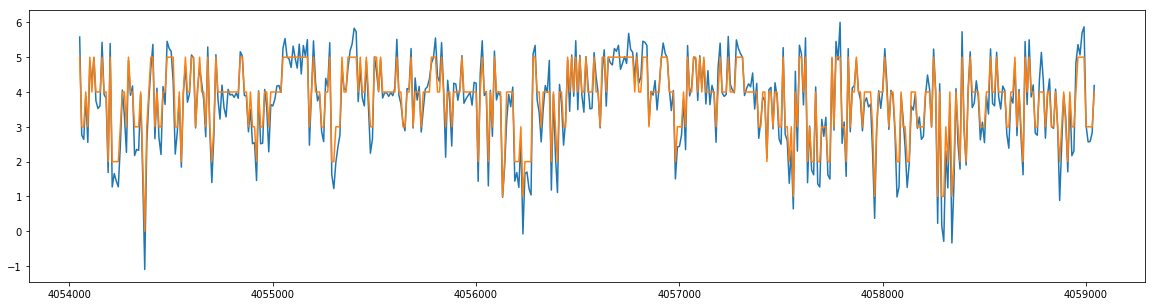

#########################
### Random 2494381 to 2499381
#########################


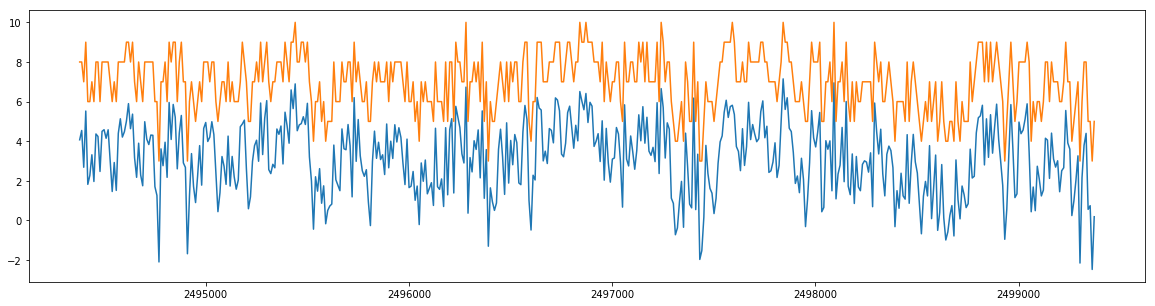

#########################
### Random 125565 to 130565
#########################


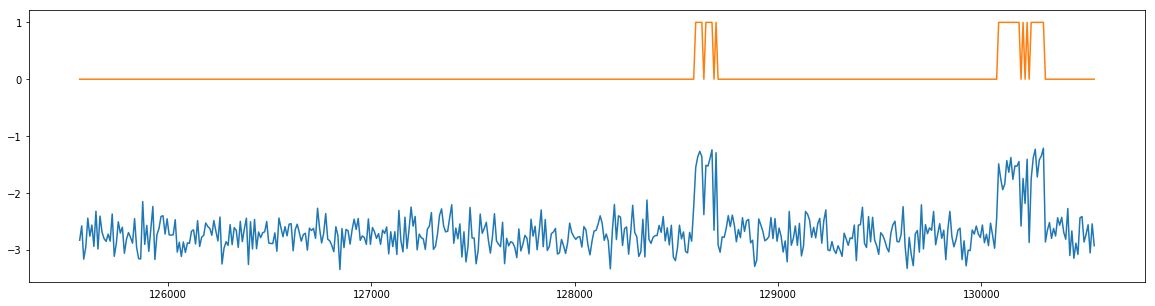

#########################
### Random 2312751 to 2317751
#########################


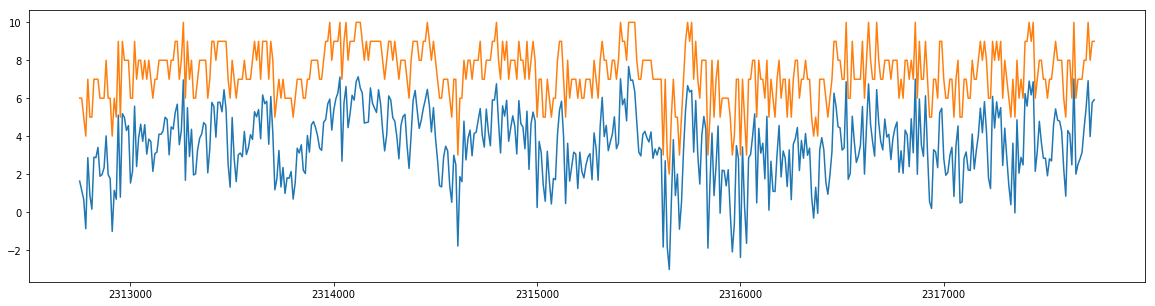

In [5]:
for k in range(10):
    a = int( np.random.uniform(0,train.shape[0]-50000) )
    b=a+5000; res=10
    print('#'*25)
    print('### Random %i to %i'%(a,b))
    print('#'*25)
    plt.figure(figsize=(20,5))
    plt.plot(range(a,b,res),train.signal[a:b][0::res])
    plt.plot(range(a,b,res),train.open_channels[a:b][0::res])
    plt.show()

# Test Data
Let's display the test data signal

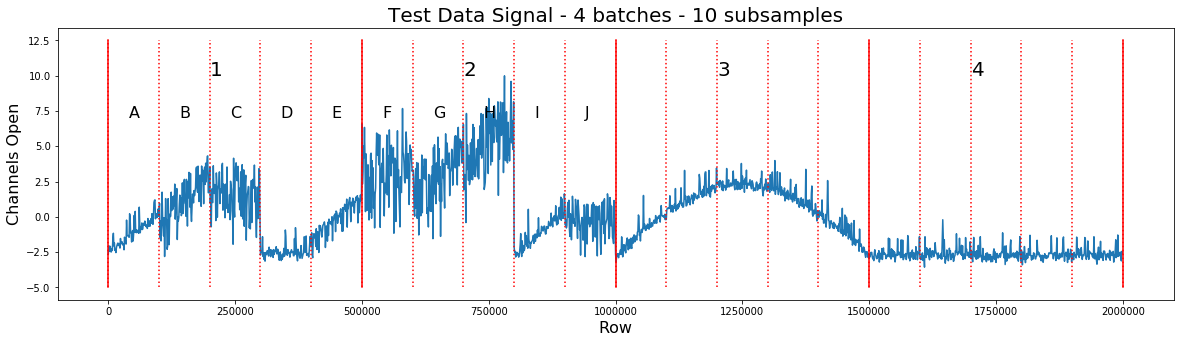

In [6]:
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,test.shape[0],res),test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(21): plt.plot([j*100000,j*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+200000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7,let[k],size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples',size=20)
plt.show()

## Reflection
From this plot we can locate the 5 models in action. And we can recognize the added drift. Batch 1 appears to be 5 subsamples where A, B, C, D, E were created by models 1s, 3, 5, 1s, 1f respectively. Model 1s is the model with maximum 1 channel open with low prob. Model 1f is the model with maximum 1 channel open with high prob. And models 3, 5, 10 are models with maximum 3, 5, 10 channels respectively. We observe slant drift in subsamples A, B, E, G, H, I. We observe parabola draft in batch 3. 

# Remove Training Data Drift
This is a demonstration to show slant drift removal. We could also remove the parabolic drift in batches 7, 8, 9, 10 if we wanted. Below we will only train our models with batches 1, 3, 4, 5, 6. But after removing training drift, we can include the data from batches 2, 7, 8, 9, 10 in our training if we want.

In [7]:
train2 = train.copy()

a=500000; b=600000 # CLEAN TRAIN BATCH 2
train2.loc[train.index[a:b],'signal'] = train2.signal[a:b].values - 3*(train2.time.values[a:b] - 50)/10.

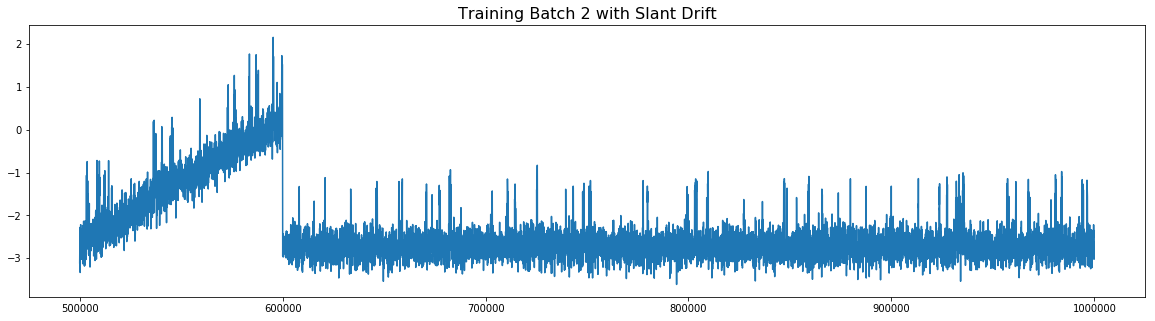

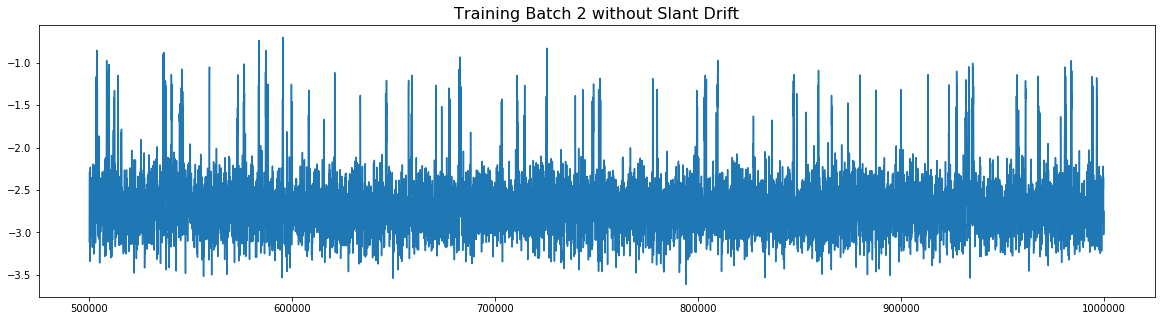

In [8]:
batch=2; a=500000*(batch-1); b=500000*batch; res=50
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train.signal[a:b][0::res])
plt.title('Training Batch 2 with Slant Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train2.signal[a:b][0::res])
plt.title('Training Batch 2 without Slant Drift',size=16)
plt.show()

In [9]:
def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

# CLEAN TRAIN BATCH 7
batch = 7; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
train2.loc[train2.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)

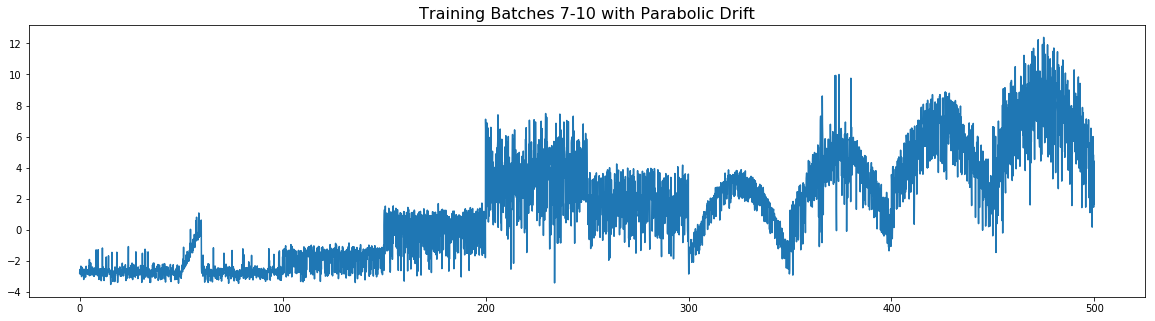

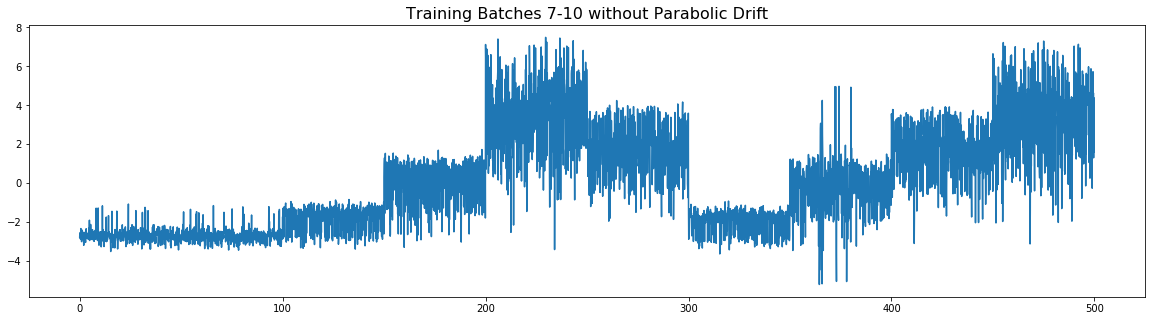

In [10]:
plt.figure(figsize=(20,5))
plt.plot(train.time[::1000],train.signal[::1000])
plt.title('Training Batches 7-10 with Parabolic Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(train2.time[::1000],train2.signal[::1000])
plt.title('Training Batches 7-10 without Parabolic Drift',size=16)
plt.show()

# Make Five Simple Models
We will make one model for each different type of signal we observed above.

## 1 Slow Open Channel

Training model 1s channel
has f1 validation score = 0.984750462652431


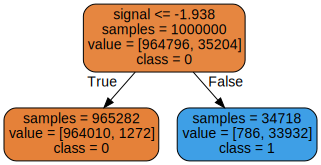

In [11]:
batch = 1; a = 500000*(batch-1); b = 500000*batch
batch = 2; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf1s = tree.DecisionTreeClassifier(max_depth=1)
clf1s = clf1s.fit(X_train,y_train)
print('Training model 1s channel')
preds = clf1s.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf1s, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

## 1 Fast Open Channel

Training model 1f channel
has f1 validation score = 0.9879287335590583


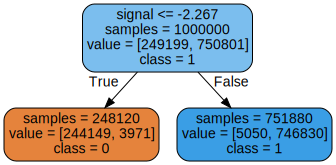

In [12]:
batch = 3; a = 500000*(batch-1); b = 500000*batch
batch = 7; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf1f = tree.DecisionTreeClassifier(max_depth=1)
clf1f = clf1f.fit(X_train, y_train)
print('Training model 1f channel')
preds = clf1f.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf1f, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

## 3 Open Channels

Training model 3 channel
has f1 validation score = 0.9321291153218245


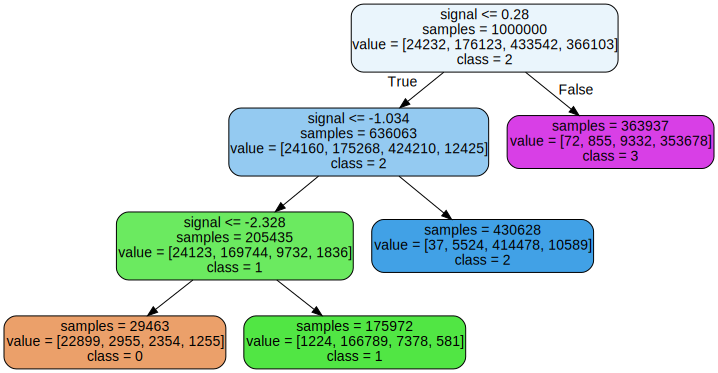

In [13]:
batch = 4; a = 500000*(batch-1); b = 500000*batch
batch = 8; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf3 = tree.DecisionTreeClassifier(max_leaf_nodes=4)
clf3 = clf3.fit(X_train,y_train)
print('Training model 3 channel')
preds = clf3.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf3, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3'],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

## 5 Open Channels

Trained model 5 channel
has f1 validation score = 0.9538294064086686


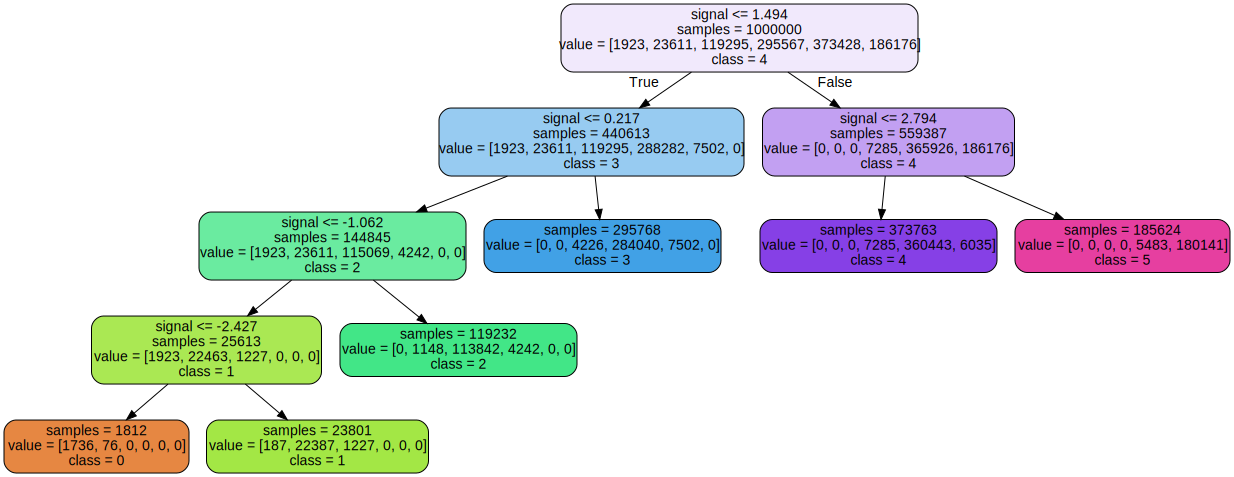

In [14]:
batch = 6; a = 500000*(batch-1); b = 500000*batch
batch = 9; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf5 = tree.DecisionTreeClassifier(max_leaf_nodes=6)
clf5 = clf5.fit(X_train, y_train)
print('Trained model 5 channel')
preds = clf5.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf5, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3','4','5'],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

## 10 Open Channels

Trained model 10 channel
has f1 validation score = 0.617082087312885


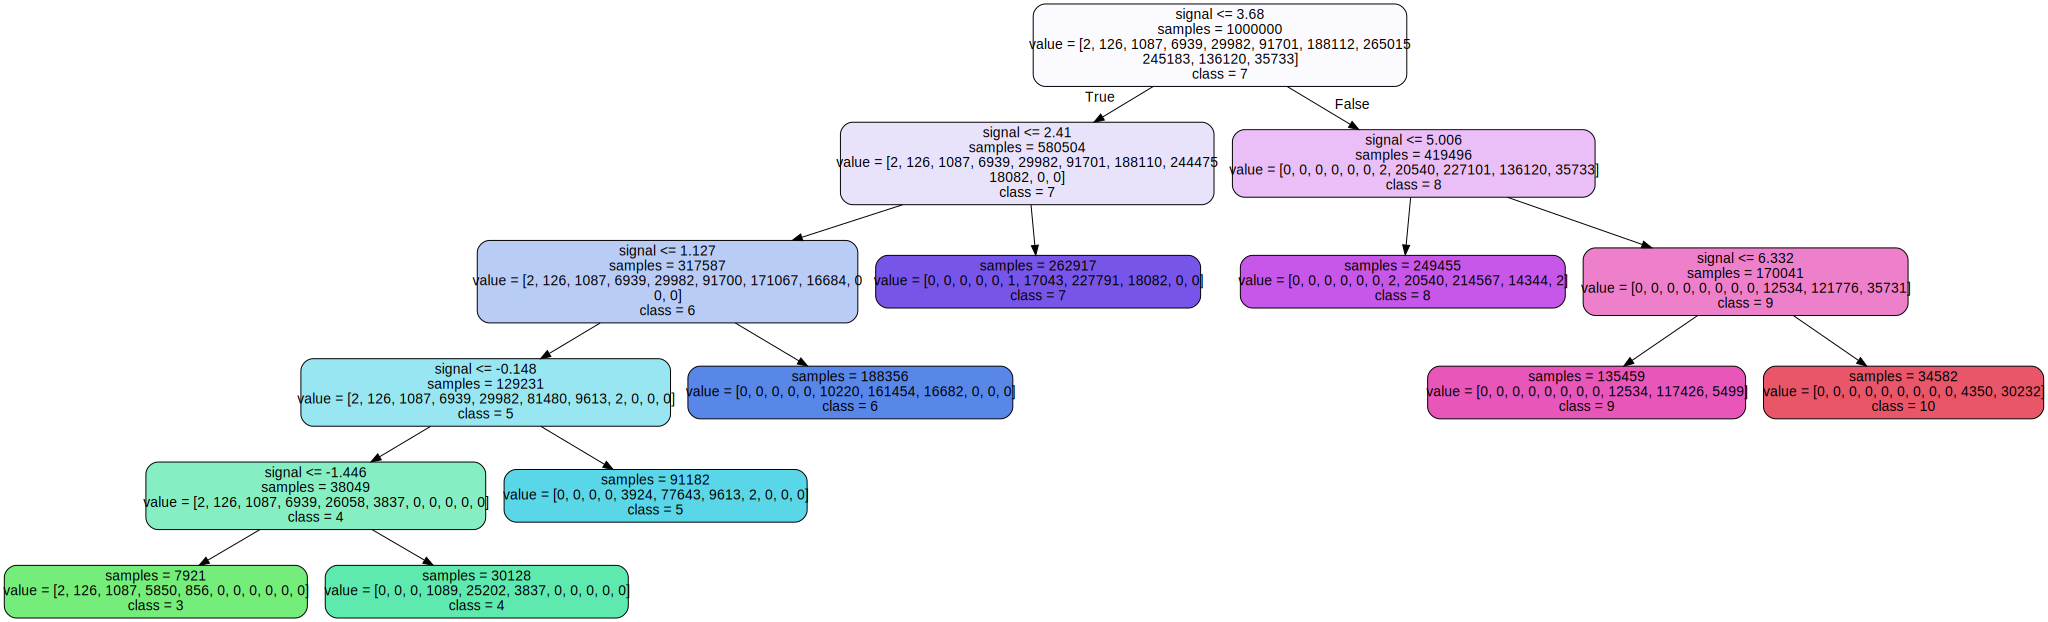

In [15]:
batch = 5; a = 500000*(batch-1); b = 500000*batch
batch = 10; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf10 = tree.DecisionTreeClassifier(max_leaf_nodes=8)
clf10 = clf10.fit(X_train, y_train)
print('Trained model 10 channel')
preds = clf10.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf10, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = [str(x) for x in range(11)],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

# Analyze Test Data Drift
Let's plot the drift in the training and test data

## Training Data Drift
We observe drift whereever the following plot is not a horizontal line. We see drift in batches 2, 7, 8, 9, 10.

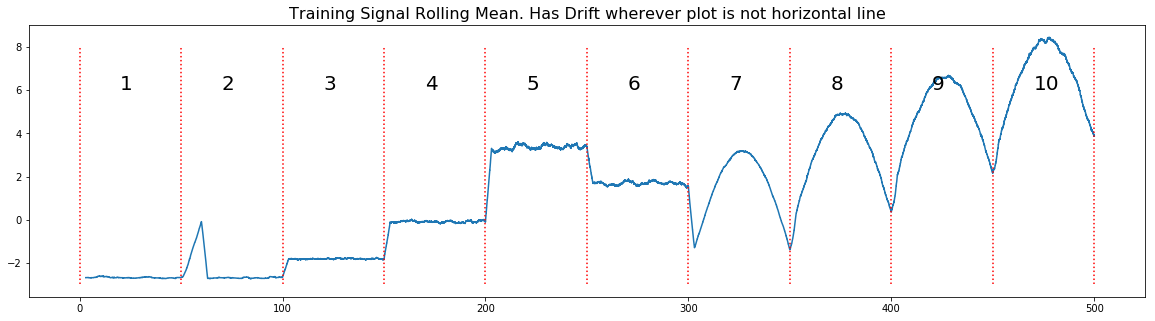

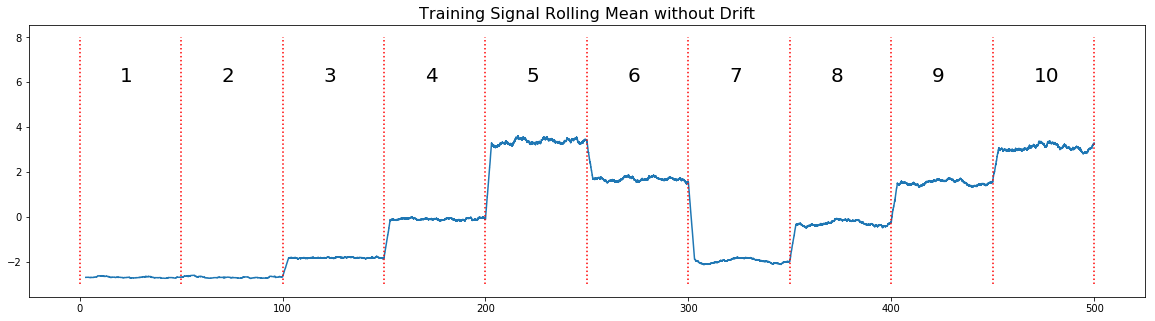

In [16]:
# ORIGINAL TRAIN DATA
plt.figure(figsize=(20,5))
r = train.signal.rolling(30000).mean()
plt.plot(train.time.values,r)
for i in range(11): plt.plot([i*50,i*50],[-3,8],'r:')
for j in range(10): plt.text(j*50+20,6,str(j+1),size=20)
plt.title('Training Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

# TRAIN DATA WITHOUT DRIFT
plt.figure(figsize=(20,5))
r = train2.signal.rolling(30000).mean()
plt.plot(train2.time.values,r)
for i in range(11): plt.plot([i*50,i*50],[-3,8],'r:')
for j in range(10): plt.text(j*50+20,6,str(j+1),size=20)
plt.title('Training Signal Rolling Mean without Drift',size=16)
plt.show()

## Test Data Drift
We observe drift in test subsamples A, B, E, G, H, I and test batch 3.


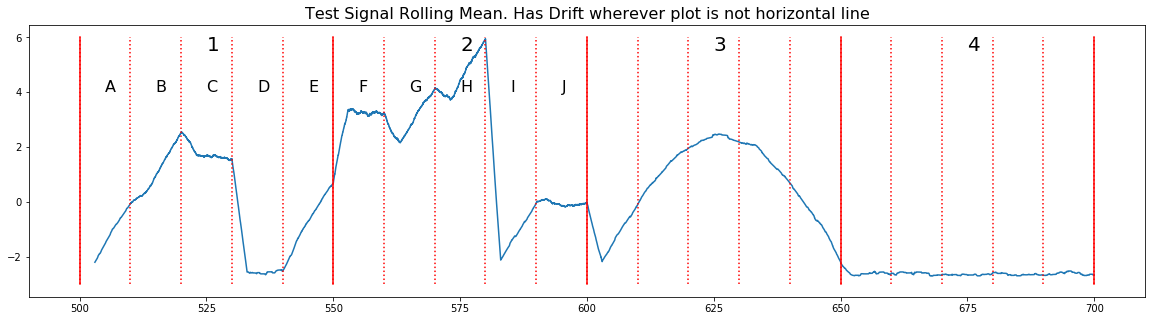

In [17]:
plt.figure(figsize=(20,5))
let = ['A','B','C','D','E','F','G','H','I','J']
r = test.signal.rolling(30000).mean()
plt.plot(test.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-3,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-3,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

# Remove Test Data Drift

In [18]:
test2 = test.copy()

In [19]:
# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.

In [20]:
# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - 3*(test2.time.values[a:b]-start)/10.

In [21]:
# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test2.loc[test2.index[a:b],'signal'] = test2.signal.values[a:b] - f(test2.time[a:b].values)

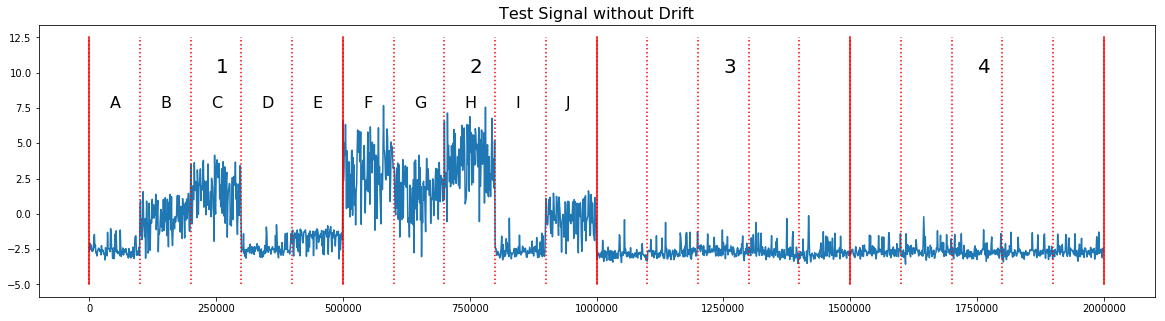

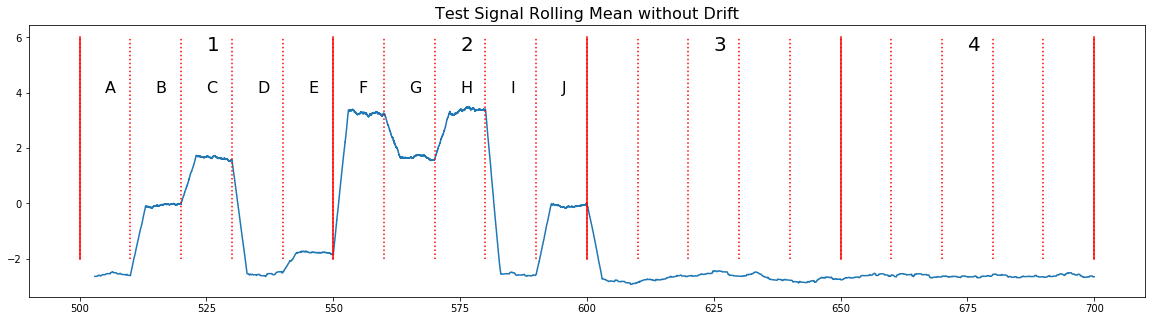

In [22]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,test2.shape[0],res),test2.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Signal without Drift',size=16)
plt.show()

plt.figure(figsize=(20,5))
r = test2.signal.rolling(30000).mean()
plt.plot(test2.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-2,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-2,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean without Drift',size=16)
plt.show()

# Predict Test


In [23]:
sub = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')

a = 0 # SUBSAMPLE A, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 1 # SUBSAMPLE B, Model 3
sub.iloc[100000*a:100000*(a+1),1] = clf3.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 2 # SUBSAMPLE C, Model 5
sub.iloc[100000*a:100000*(a+1),1] = clf5.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 3 # SUBSAMPLE D, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 4 # SUBSAMPLE E, Model 1f
sub.iloc[100000*a:100000*(a+1),1] = clf1f.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 5 # SUBSAMPLE F, Model 10
sub.iloc[100000*a:100000*(a+1),1] = clf10.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 6 # SUBSAMPLE G, Model 5
sub.iloc[100000*a:100000*(a+1),1] = clf5.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 7 # SUBSAMPLE H, Model 10
sub.iloc[100000*a:100000*(a+1),1] = clf10.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 8 # SUBSAMPLE I, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 9 # SUBSAMPLE J, Model 3
sub.iloc[100000*a:100000*(a+1),1] = clf3.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

 # BATCHES 3 AND 4, Model 1s
sub.iloc[1000000:2000000,1] = clf1s.predict(test2.signal.values[1000000:2000000].reshape((-1,1)))

# Display Test Predictions

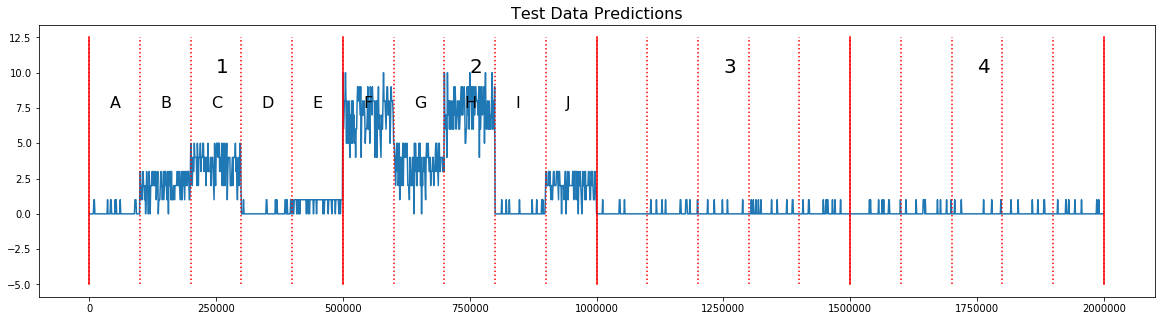

In [24]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,test.shape[0],res),sub.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()

In [25]:
sub.to_csv('submission.csv',index=False,float_format='%.4f')